In [1]:
# This notebook demonstrates fitting a PS by bspline
# And this time we only fit the residual wrt an analytic expression

In [2]:
%pylab inline
import jax_cosmo as jc
import jax.numpy as np
import jax

Populating the interactive namespace from numpy and matplotlib


In [6]:
# Ok, so first thing is loading the data
from astropy.io import fits
k = np.logspace(-4, 1, 512,endpoint=False)

# First building the training set
ps = []
param = []
for i in range(50):
    batch_params = fits.getdata('/data2/camb/params_%03d.fits'%i).astype('float32')
    batch_data = fits.getdata('/data2/camb/data_%03d.fits'%i).astype('float32')
    
    ps.append(batch_data)
    param.append(batch_params)
ps_training = np.concatenate(ps, axis=0)
param_training = np.concatenate(param, axis=0)


# Now building the testing set
ps = []
param = []
for i in range(50, 61):
    batch_params = fits.getdata('/data2/camb/params_%03d.fits'%i).astype('float32')
    batch_data = fits.getdata('/data2/camb/data_%03d.fits'%i).astype('float32')
    
    ps.append(batch_data)
    param.append(batch_params)
ps_testing= np.concatenate(ps, axis=0)
param_testing = np.concatenate(param, axis=0)

In [66]:
# Now we need a function that extracts batches
# function that generates batches of params and pk from prior
import numpy as onp
batch_size=128

def get_batch_training():
    inds = onp.random.choice(len(ps_training), batch_size)
    
    p = param_training[inds]
    pks = ps_training[inds]
    # Return relative difference between CAMB/BBKS
    return {'x':p, 'y': (pks[:,1]/pks[:,0] - 1.),
            'ref':pks[:,0],
            'target':pks[:,1]}


def get_batch_testing():
    inds = onp.random.choice(len(ps_training), batch_size)
    
    p = param_testing[inds]
    pks = ps_testing[inds]
    # Return relative difference between CAMB/BBKS
    return {'x':p, 'y': (pks[:,1]/pks[:,0] - 1.),
            'ref':pks[:,0],
            'target':pks[:,1]}

In [21]:
def deBoorVectorized(x, t, c, p):
    """
    Evaluates S(x).

    Args
    ----
    x: position
    t: array of knot positions, needs to be padded as described above
    c: array of control points
    p: degree of B-spline
    """
    k = np.digitize(x, t) -1
    
    d = [c[j + k - p] for j in range(0, p+1)]
    for r in range(1, p+1):
        for j in range(p, r-1, -1):
            alpha = (x - t[j+k-p]) / (t[j+1+k-r] - t[j+k-p])
            d[j] = (1.0 - alpha) * d[j-1] + alpha * d[j]
    return d[p]

In [22]:
import flax
from flax import nn, optim
from functools import partial

class emulator(nn.Module):
    def apply(self, p, x):
        
        bs = p.shape[0]
        
        net = nn.leaky_relu(nn.Dense(p, 256))
        net = nn.leaky_relu(nn.Dense(net, 256))
                
        w = nn.Dense(net, 34)
        k = nn.Dense(net, 31)
                
        # make sure the knots sum to 1 and are in the interval 0,1
        k = np.concatenate([np.zeros((bs,1)), 
                            np.cumsum(nn.activation.softmax(k,axis=1), axis=1)],
                            axis=1)
        
        # Augment with repeating points
        ak = np.concatenate([np.zeros((bs, 3)), k, np.ones((bs,3))],axis=1)
                
        @partial(jax.vmap, in_axes=(0,0))
        def eval_spline(a, c):
            return deBoorVectorized(x, a, c, 3)
        
        return  eval_spline(ak, w)

In [23]:
x = np.linspace(0,1,512, endpoint=False)

In [24]:
_, initial_params = emulator.init_by_shape(jax.random.PRNGKey(0),
                                           [((1, 5), np.float32), ((512,), np.float32)])
model = flax.nn.Model(emulator, initial_params)

In [25]:
batch = get_batch_training()

In [26]:
batch['x'].shape, batch['y'].shape

((128, 5), (128, 512))

In [27]:
model(batch['x'], x).shape

(128, 512)

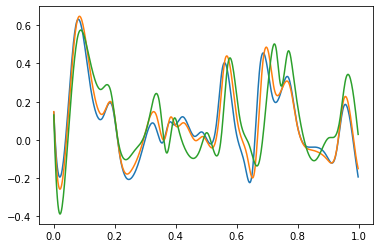

In [28]:
plot(x, model(batch['x'], x)[0])
plot(x, model(batch['x'], x)[1])
plot(x, model(batch['x'], x)[3])

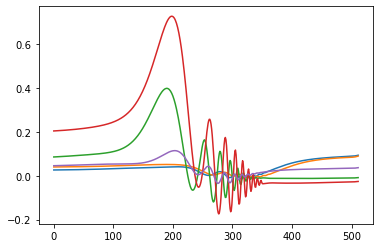

In [29]:
plot(batch['y'][0])
plot(batch['y'][1])
plot(batch['y'][2])
plot(batch['y'][3])
plot(batch['y'][4])

In [30]:
@jax.jit
def train_step(optimizer, batch):
  def loss_fn(model):
    pred_y = model(batch['x'], x)
    loss = np.sum(((pred_y - batch['y'])**2), axis=1).mean() 
    return loss
  l, grad = jax.value_and_grad(loss_fn)(optimizer.target)
  optimizer = optimizer.apply_gradient(grad)
  return optimizer,l 

In [31]:
# We also need an optimizer
optimizer = flax.optim.Momentum(learning_rate=0.001, beta=0.9).create(model)

In [32]:
losses = []

In [38]:
for i in range(10000):
    batch = get_batch_training()
    optimizer, l = train_step(optimizer, batch)
    losses.append(l)
    if i%1000 ==0:
        print(l)

0.23909724
0.08703742
0.049341314
0.0650464
0.060132116
0.019602146
0.022464857
0.022369204
0.017245756
0.012985888


In [51]:
for i in range(100000):
    batch = get_batch_training()
    optimizer, l = train_step(optimizer, batch)
    losses.append(l)
    if i%1000 ==0:
        print(l)

0.004165348
0.005438166
0.0036564525
0.0048670527
0.0049678264
0.004302544
0.0041978764
0.006558222
0.0040452788
0.0043567643


KeyboardInterrupt: 

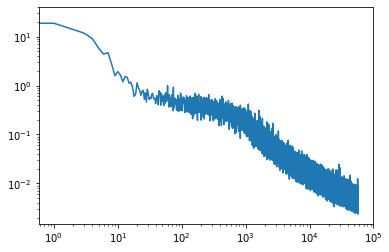

In [52]:
loglog(losses)

(0.0, 1.0)

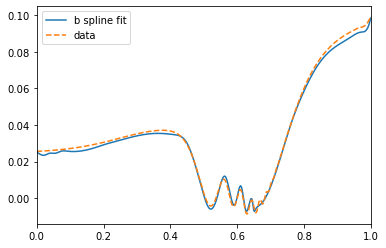

In [53]:
plot(x, optimizer.target(batch['x'], x)[0], label='b spline fit')
plot(x,batch['y'][0],'--', label='data')
legend()
xlim(0,1)

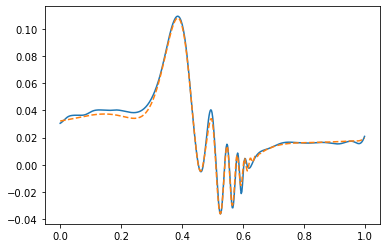

In [54]:
plot(x, optimizer.target(batch['x'], x)[1], label='b spline fit')
plot(x,batch['y'][1],'--', label='data')

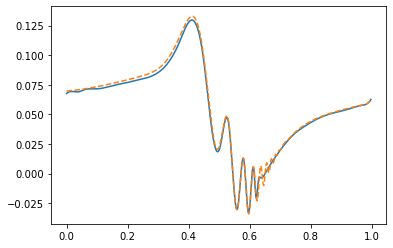

In [55]:
plot(x, optimizer.target(batch['x'], x)[2], label='b spline fit')
plot(x,batch['y'][2],'--', label='data')

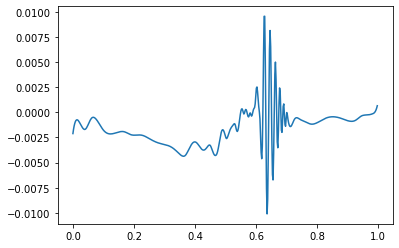

In [56]:
plot(x, optimizer.target(batch['x'], x)[2]- batch['y'][2], label='b spline fit')

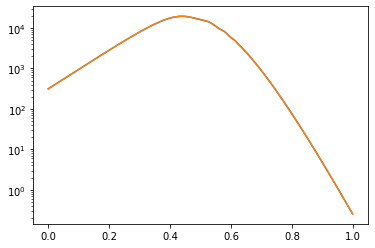

In [61]:
semilogy(x, (optimizer.target(batch['x'], x)[2] +1)*batch['ref'][2])
semilogy(x, batch['target'][2])

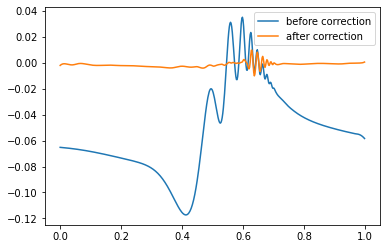

In [65]:
plot(x, batch['ref'][2]/batch['target'][2] - 1, label='before correction')
plot(x, (optimizer.target(batch['x'], x)[2] +1)*batch['ref'][2]/batch['target'][2] - 1, label='after correction')
legend()

In [67]:
# Let's check the same thing but on the testing set now
batch = get_batch_testing()

(0.0, 1.0)

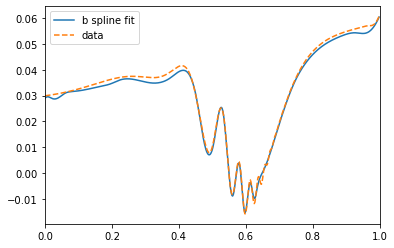

In [68]:
plot(x, optimizer.target(batch['x'], x)[0], label='b spline fit')
plot(x,batch['y'][0],'--', label='data')
legend()
xlim(0,1)

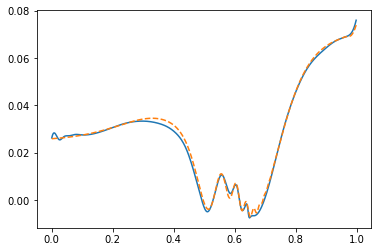

In [69]:
plot(x, optimizer.target(batch['x'], x)[1], label='b spline fit')
plot(x,batch['y'][1],'--', label='data')

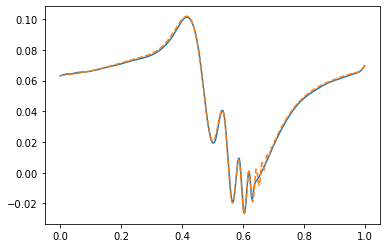

In [71]:
plot(x, optimizer.target(batch['x'], x)[2], label='b spline fit')
plot(x,batch['y'][2],'--', label='data')

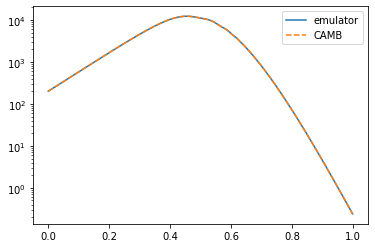

In [75]:
semilogy(x, (optimizer.target(batch['x'], x)[2] +1)*batch['ref'][2], label='emulator')
semilogy(x, batch['target'][2], '--', label='CAMB')
legend()

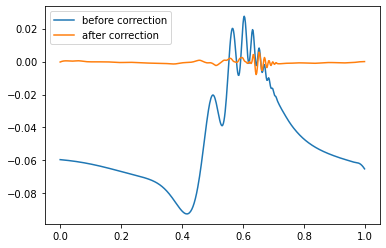

In [72]:
plot(x, batch['ref'][2]/batch['target'][2] - 1, label='before correction')
plot(x, (optimizer.target(batch['x'], x)[2] +1)*batch['ref'][2]/batch['target'][2] - 1, label='after correction')
legend()

In [44]:
class emulator_eval(nn.Module):
    def apply(self, p, x):
        
        bs = p.shape[0]
        
        net = nn.leaky_relu(nn.Dense(p, 256))
        net = nn.leaky_relu(nn.Dense(net, 256))
                
        w = nn.Dense(net, 34)
        k = nn.Dense(net, 31)
                
        # make sure the knots sum to 1 and are in the interval 0,1
        k = np.concatenate([np.zeros((bs,1)), 
                            np.cumsum(nn.activation.softmax(k,axis=1), axis=1)],
                            axis=1)
        
        # Augment with repeating points
        ak = np.concatenate([np.zeros((bs, 3)), k, np.ones((bs,3))],axis=1)
                
        # Let's inspect the predictions
        return ak, w

In [77]:
model_eval = flax.nn.Model(emulator_eval, optimizer.target.params)

In [78]:
k,w =  model_eval(batch['x'], x)


In [79]:
k.shape

(128, 38)

In [80]:
w.shape

(128, 34)

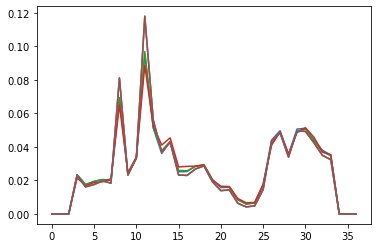

In [82]:
plot(k[0][1:]-k[0][:-1])
plot(k[1][1:]-k[1][:-1])
plot(k[2][1:]-k[2][:-1])
plot(k[3][1:]-k[3][:-1])
plot(k[4][1:]-k[4][:-1])
plot(k[5][1:]-k[5][:-1])